In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Sequence, Tuple, List, Dict, Any

import seaborn as sns
sns.set_theme()

import warnings

In [16]:
from typing import Optional, Sequence, Tuple, List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


def sql_fit(
    *meta_dfs: pd.DataFrame,
    labels: Optional[Sequence[str]] = None,
    n_logbins: int = 30,
    min_count: int = 20,
    use_median: bool = False,
    figsize: Tuple[float, float] = (10, 6.5),
    show_points: bool = True,
    save_path: Optional[str] = None,
) -> List[Dict[str, Any]]:
    """
    Fit I/sigma = Y * (Q/V)^gamma on an arbitrary number of metaorder DataFrames
    and plot all fits together on a single log–log chart.

    Each DataFrame needs columns: 'Q/V', 'Price Change', 'Direction', 'Daily Vol'.
    """
    if not meta_dfs:
        raise ValueError("Provide at least one DataFrame.")

    # styling
    LABEL_SIZE, LEGEND_SIZE, TITLE_SIZE = 16, 14, 18
    plt.rcParams.update({
        "axes.labelsize": LABEL_SIZE,
        "axes.titlesize": TITLE_SIZE,
        "legend.fontsize": LEGEND_SIZE,
    })

    # ---------- utils ----------
    req_cols = {'Q/V', 'Price Change', 'Direction', 'Daily Vol'}

    def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
        """Coerce columns to 1-D float arrays and compute Impact safely."""
        if not req_cols.issubset(df.columns):
            missing = req_cols - set(df.columns)
            raise ValueError(f"Missing required columns: {missing}")

        qv  = pd.to_numeric(df['Q/V'], errors='coerce').to_numpy().astype(float)
        pc  = pd.to_numeric(df['Price Change'], errors='coerce').to_numpy().astype(float)
        dr  = pd.to_numeric(df['Direction'], errors='coerce').to_numpy().astype(float)
        vol = pd.to_numeric(df['Daily Vol'], errors='coerce').to_numpy().astype(float)

        # compute impact
        impact = pc * dr / vol

        # basic mask (finite + positive Q/V)
        mask = np.isfinite(qv) & np.isfinite(impact) & (qv > 1e-5)
        if not np.any(mask):
            raise ValueError("No valid rows after coercion/filters (check columns for non-numeric values).")

        return pd.DataFrame({'Q/V': qv[mask], 'Impact': impact[mask]})

    def power_law(qv: np.ndarray, Y: float, gamma: float) -> np.ndarray:
        return Y * np.power(qv, gamma)

    def fit_power_law_logbins_wls(subdf: pd.DataFrame) -> Tuple[pd.DataFrame, Tuple[float, ...], Tuple[float, float]]:
        """Log-binning + WLS in log–log space with delta-method weights."""
        x = subdf['Q/V'].to_numpy(dtype=float).ravel()
        y = subdf['Impact'].to_numpy(dtype=float).ravel()

        # support
        x_min = float(np.nanmin(x))
        x_max = float(np.nanmax(x))
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            raise ValueError("Invalid Q/V range for log binning.")

        edges = np.logspace(np.log10(x_min), np.log10(x_max), int(n_logbins) + 1)

        # binning
        bin_idx = np.digitize(x, edges) - 1
        mask = (bin_idx >= 0) & (bin_idx < n_logbins) & np.isfinite(y)
        x, y, bin_idx = x[mask], y[mask], bin_idx[mask]

        dfb = pd.DataFrame({'x': x, 'y': y, 'bin': bin_idx})
        agg = (
            dfb.groupby('bin', sort=True)['y']
               .agg(mean_imp='mean',
                    median_imp='median',
                    std_imp=lambda s: s.std(ddof=1),
                    count='size')
        )

        y_stat = agg['median_imp'] if use_median else agg['mean_imp']
        y_std  = agg['std_imp'].to_numpy()
        n      = agg['count'].to_numpy()
        sem    = y_std / np.sqrt(np.maximum(n, 1))

        bins_present = agg.index.to_numpy()
        left_edges   = edges[bins_present]
        right_edges  = edges[bins_present + 1]
        x_center     = np.sqrt(left_edges * right_edges)

        binned = pd.DataFrame({
            'center_QV': x_center,
            'mean_imp':  y_stat.to_numpy(),
            'std_imp':   y_std,
            'sem_imp':   sem,
            'count':     n
        }).sort_values('center_QV').reset_index(drop=True)

        # reliability/positivity filters for log fit
        binned = binned[
            (binned['count'] >= min_count) &
            np.isfinite(binned['mean_imp']) &
            np.isfinite(binned['sem_imp']) &
            (binned['sem_imp'] > 0) &
            (binned['mean_imp'] > 0)
        ]
        if len(binned) < 3:
            raise ValueError(f"Not enough valid bins after filtering (got {len(binned)}).")

        X = np.log(binned['center_QV'].to_numpy())
        Z = np.log(binned['mean_imp'].to_numpy())

        # weights via delta method
        var_logy = (binned['sem_imp'].to_numpy() / binned['mean_imp'].to_numpy())**2
        w = np.where(np.isfinite(var_logy) & (var_logy > 0), 1.0 / var_logy, 0.0)

        # WLS: Z = a + gamma * X  (Y = exp(a))
        A = np.vstack([np.ones_like(X), X]).T
        Aw = A * np.sqrt(w)[:, None]
        Zw = Z * np.sqrt(w)
        coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
        a_hat, gamma_hat = [float(c) for c in coef]
        Y_hat = float(np.exp(a_hat))

        # SEs
        res  = Z - (a_hat + gamma_hat * X)
        RSS  = float(np.sum(w * res**2))
        dof  = max(len(Z) - 2, 1)
        s2   = RSS / dof
        XtWX = A.T @ (w[:, None] * A)
        cov  = s2 * np.linalg.inv(XtWX)
        a_se, gamma_se = [float(np.sqrt(v)) for v in np.diag(cov)]
        Y_se = float(Y_hat * a_se)

        # R^2 (log) and linear scale (informal)
        Zhat = a_hat + gamma_hat * X
        Zbar = float(np.average(Z, weights=w))
        R2_log = float(1.0 - np.sum(w * (Z - Zhat)**2) / np.sum(w * (Z - Zbar)**2))

        yhat   = power_law(binned['center_QV'].to_numpy(), Y_hat, gamma_hat)
        ybar   = float(np.mean(binned['mean_imp'].to_numpy()))
        R2_lin = float(1.0 - np.sum((binned['mean_imp'].to_numpy() - yhat)**2) /
                       np.sum((binned['mean_imp'].to_numpy() - ybar)**2))

        return binned, (Y_hat, Y_se, gamma_hat, gamma_se, R2_log, R2_lin), (float(binned['center_QV'].min()), float(binned['center_QV'].max()))

    def plot_fit(ax: plt.Axes, binned: pd.DataFrame, params, label_prefix: Optional[str]):
        Y, Y_err, gamma, gamma_err, _, _ = params
        if show_points:
            ax.errorbar(
                binned['center_QV'],
                binned['mean_imp'],
                yerr=binned['sem_imp'],
                fmt='o', alpha=0.6, ecolor='gray', ms=6,
                label='Bin means ± SEM' if label_prefix is None else f'{label_prefix}'
            )
        x_min, x_max = binned['center_QV'].min(), binned['center_QV'].max()
        x_grid = np.logspace(np.log10(x_min), np.log10(x_max), 300)
        ax.plot(
            x_grid, power_law(x_grid, Y, gamma), linestyle='--',
            label=(rf'{"" if label_prefix is None else label_prefix + ": "}'
                   rf'$I/\sigma = ({Y:.3g}\pm{Y_err:.2g})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$')
        )

    # labels
    if labels is not None and len(labels) != len(meta_dfs):
        raise ValueError("`labels` length must match number of input DataFrames.")
    if labels is None:
        labels = [f"Set {i+1}" for i in range(len(meta_dfs))]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Q/V'); ax.set_ylabel(r'I / $\sigma$')
    results: List[Dict[str, Any]] = []
    plotted_any = False

    for df, lab in zip(meta_dfs, labels):
        try:
            sub = prepare_df(df)
            binned_i, params_i, x_rng_i = fit_power_law_logbins_wls(sub)
            plot_fit(ax, binned_i, params_i, label_prefix=lab)
            plotted_any = True

            Y, Y_se, g, g_se, R2_log, R2_lin = params_i
            print(f'--- {lab} ---')
            print(f'Y = {Y:.6g} ± {Y_se:.3g}')
            print(f'γ = {g:.6f} ± {g_se:.3g}')
            print(f'R²_log = {R2_log:.4f} | R²_lin = {R2_lin:.4f}')
            print(f'Bins used: {len(binned_i)} (min_count ≥ {min_count})\n')

            results.append({
                'label': lab, 'Y': Y, 'Y_se': Y_se,
                'gamma': g, 'gamma_se': g_se,
                'R2_log': R2_log, 'R2_lin': R2_lin,
                'bins_used': int(len(binned_i)),
                'binned_df': binned_i, 'x_range': x_rng_i,
            })
        except Exception as e:
            warnings.warn(f"[{lab}] skipped: {e}")

    if plotted_any:
        ax.set_title('Power-law fits across datasets')
        ax.legend(loc='best')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()
    else:
        plt.close(fig)
        warnings.warn("No dataset produced a valid fit/plot. Check data types and required columns.")

    return results


In [12]:
meta_client = pd.read_parquet('out_files/metaorders_info_sameday_filtered_client.parquet')
meta_member = pd.read_parquet('out_files/metaorders_info_sameday_filtered_member.parquet')
meta_prop_member = pd.read_parquet('out_files/metaorders_info_sameday_filtered_member_prop.parquet')

meta_client_mot = pd.read_parquet('out_files/metaorders_info_sameday_filtered_mot_client.parquet')
meta_member_mot = pd.read_parquet('out_files/metaorders_info_sameday_filtered_mot_member.parquet')
meta_prop_member_mot = pd.read_parquet('out_files/metaorders_info_sameday_filtered_mot_member_prop.parquet')

In [13]:
meta_client

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,1092,1092,1,-0.000422,0.070867,5012.0,1.248219e-02,0.426481,2,"[2024-06-03T09:53:56.316255, 2024-06-03T10:03:..."
1,IT0000062072,1092,1092,-1,-0.002107,0.070867,7950.0,1.979917e-02,0.706290,2,"[2024-06-03T10:50:13.647892, 2024-06-03T11:04:..."
2,IT0000062072,1092,1092,1,0.000000,0.059031,1417.0,1.953346e-03,0.020753,2,"[2024-06-05T14:46:41.476554, 2024-06-05T15:24:..."
3,IT0000062072,1092,1092,-1,0.000423,0.085787,6920.0,1.318665e-02,0.225429,2,"[2024-06-06T12:00:57.728271, 2024-06-06T12:35:..."
4,IT0000062072,1092,1092,-1,0.000000,0.085787,1760.0,3.353831e-03,0.041746,3,"[2024-06-06T13:24:06.140812, 2024-06-06T14:22:..."
...,...,...,...,...,...,...,...,...,...,...,...
909544,NL0015435975,2015,2015,-1,-0.001407,0.081117,631.0,6.256879e-04,0.007366,2,"[2025-05-28T11:48:04.982097, 2025-05-28T12:44:..."
909545,NL0015435975,2015,2015,1,-0.006571,0.097384,637.0,3.152019e-04,0.012475,2,"[2025-05-30T14:05:06.967816, 2025-05-30T14:09:..."
909546,NL0015435975,57655941,57655941,1,-0.001747,0.138848,2.0,5.199774e-07,0.000019,2,"[2025-05-29T14:33:23.106839, 2025-05-29T14:44:..."
909547,NL0015435975,59266,59266,-1,0.000000,0.138848,1707.0,4.438007e-04,0.212604,2,"[2025-05-29T16:17:52.626242, 2025-05-29T16:23:..."


--- Broker ---
Y = 0.0790062 ± 0.00725
γ = 0.548706 ± 0.0188
R²_log = 0.9748 | R²_lin = 0.4197
Bins used: 24 (min_count ≥ 20)

--- Proprietary ---
Y = 0.0534817 ± 0.00243
γ = 0.390189 ± 0.00773
R²_log = 0.9895 | R²_lin = 0.8308
Bins used: 29 (min_count ≥ 20)

--- Client ---
Y = 0.100212 ± 0.016
γ = 0.612974 ± 0.036
R²_log = 0.9414 | R²_lin = -2.4474
Bins used: 20 (min_count ≥ 20)



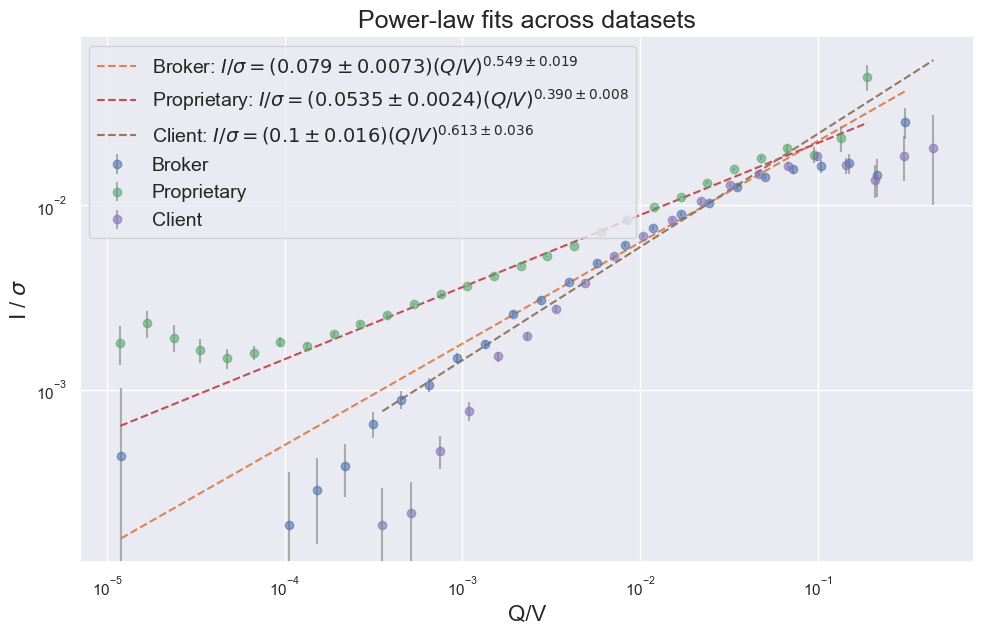

[{'label': 'Broker',
  'Y': 0.07900624706293986,
  'Y_se': 0.007250057894623263,
  'gamma': 0.5487058639307502,
  'gamma_se': 0.018795248039184965,
  'R2_log': 0.974836481056812,
  'R2_lin': 0.41972056019135684,
  'bins_used': 24,
  'binned_df':     center_QV  mean_imp   std_imp   sem_imp  count
  0    0.000012  0.000438  0.023730  0.000593   1599
  6    0.000106  0.000186  0.020157  0.000173  13576
  7    0.000152  0.000289  0.019822  0.000142  19396
  8    0.000219  0.000386  0.020110  0.000123  26639
  9    0.000314  0.000657  0.020042  0.000108  34514
  10   0.000451  0.000886  0.020118  0.000097  42882
  11   0.000649  0.001065  0.020747  0.000092  50681
  12   0.000933  0.001496  0.021125  0.000088  57248
  13   0.001341  0.001787  0.021978  0.000089  60948
  14   0.001927  0.002574  0.023100  0.000093  61995
  15   0.002770  0.003073  0.024294  0.000099  59947
  16   0.003982  0.003842  0.025875  0.000111  54087
  17   0.005724  0.004856  0.027603  0.000128  46579
  18   0.00822

In [21]:
sql_fit(meta_member, meta_prop_member, meta_client, labels=['Broker', 'Proprietary', 'Client'], n_logbins=30, min_count=20, use_median=False, figsize=(10,6.5), show_points=True, save_path='images/sql_fit_ftsmib.png')

--- Broker ---
Y = 0.0276371 ± 0.00349
γ = 0.457604 ± 0.033
R²_log = 0.9014 | R²_lin = -0.5339
Bins used: 23 (min_count ≥ 20)

--- Proprietary ---
Y = 0.020969 ± 0.00148
γ = 0.295599 ± 0.0187
R²_log = 0.9120 | R²_lin = 0.8682
Bins used: 26 (min_count ≥ 20)

--- Client ---
Y = 0.0436251 ± 0.00525
γ = 0.536767 ± 0.0331
R²_log = 0.9327 | R²_lin = -1.1516
Bins used: 21 (min_count ≥ 20)



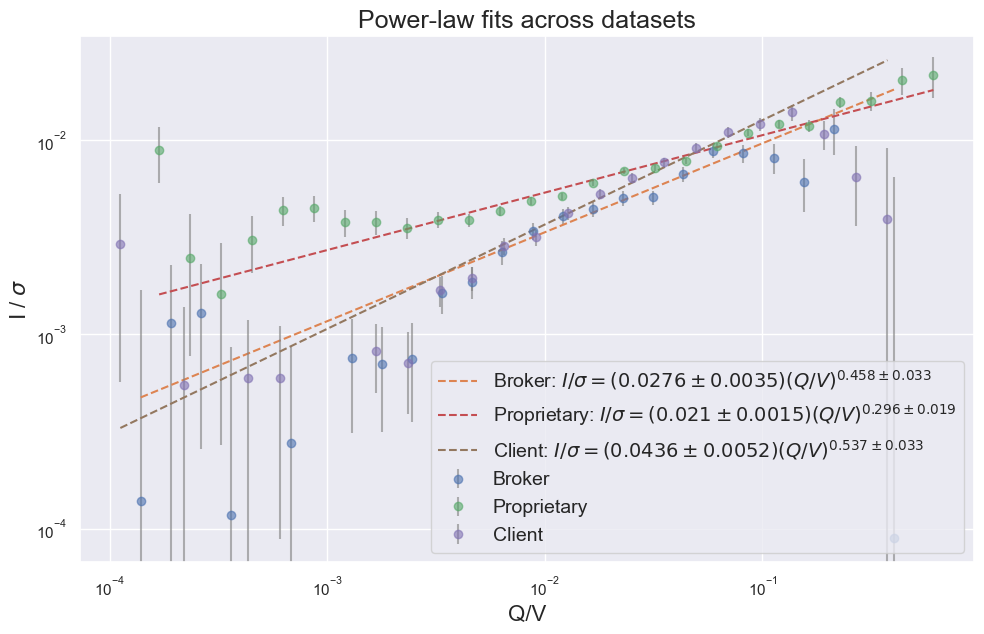

[{'label': 'Broker',
  'Y': 0.02763709462186425,
  'Y_se': 0.0034862386202917242,
  'gamma': 0.45760394099625357,
  'gamma_se': 0.03302284722070672,
  'R2_log': 0.9014185290279682,
  'R2_lin': -0.533904938753776,
  'bins_used': 23,
  'binned_df':     center_QV  mean_imp   std_imp   sem_imp  count
  4    0.000138  0.000139  0.012136  0.001554     61
  5    0.000191  0.001147  0.011319  0.001126    101
  6    0.000262  0.001283  0.013478  0.001025    173
  7    0.000361  0.000117  0.012289  0.000741    275
  9    0.000683  0.000277  0.014335  0.000596    579
  11   0.001293  0.000759  0.013807  0.000448    949
  12   0.001779  0.000707  0.013792  0.000391   1243
  13   0.002447  0.000749  0.015095  0.000394   1467
  14   0.003368  0.001639  0.015443  0.000368   1757
  15   0.004634  0.001864  0.015621  0.000347   2025
  16   0.006376  0.002651  0.016461  0.000362   2072
  17   0.008772  0.003414  0.015719  0.000344   2086
  18   0.012070  0.004056  0.016315  0.000381   1837
  19   0.0166

In [20]:
sql_fit(meta_member_mot, meta_prop_member_mot, meta_client_mot, labels=['Broker', 'Proprietary', 'Client'], n_logbins=30, min_count=20, use_median=False, figsize=(10,6.5), show_points=True, save_path='images/sql_fit_mot.png')